In [6]:
import numpy as np
# import visualize_robot_pov_plotly as v
import pickle
import importlib
import matplotlib.pyplot as plt
import torch.nn as nn
import lstm_model as m
import transformer_model as tm
import bilstm_model as bm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
import torch.utils.data as data
import torch
import data_processing as d
from IPython.display import HTML

# importlib.reload(v)
importlib.reload(m)
importlib.reload(tm)
importlib.reload(bm)
importlib.reload(d)
from preprocess_vis_data import DataPointSet

In [7]:
# load data from all processed pickles, filter short seqs, normalize key names, report label distribution
import glob
import preprocess_vis_data as pv
import os

min_len = 10
required_keys = [k.lower() for k in d.keypoint_names_training]
pkl_dir = "../../../datasets/processed"
pkl_paths = sorted(glob.glob(os.path.join(pkl_dir, "preproc_out_*.pkl")))

# Map MINT keypoint names (capitalized YOLO format) to training format (lowercase)
MINT_TO_TRAINING = {
    "Nose": "nose",
    "Left Eye": "eye_left",
    "Right Eye": "eye_right",
    "Left Ear": "ear_left",
    "Right Ear": "ear_right",
    "Left Shoulder": "shoulder_left",
    "Right Shoulder": "shoulder_right",
    "Left Elbow": "elbow_left",
    "Right Elbow": "elbow_right",
    "Left Wrist": "wrist_left",
    "Right Wrist": "wrist_right",
    "Left Hip": "hip_left",
    "Right Hip": "hip_right",
    "Left Knee": "knee_left",
    "Right Knee": "knee_right",
    "Left Ankle": "ankle_left",
    "Right Ankle": "ankle_right",
}

class DPSUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "DataPointSet" and module in {"__main__", "preprocess_vis_data"}:
            return pv.DataPointSet
        return super().find_class(module, name)

robot_trajs_all = []
human_trajs_dv = []  # Dataverse trajectories (pickles 1-2)
human_trajs_mint = []  # MINT trajectories (pickles 3-4)

for pkl_idx, path in enumerate(pkl_paths):
    with open(path, "rb") as f:
        r, h = DPSUnpickler(f).load()
    robot_trajs_all.extend(r)
    
    # pkl_idx 0,1 = Dataverse; pkl_idx 2,3 = MINT
    if pkl_idx < 2:
        human_trajs_dv.extend(h)
    else:
        human_trajs_mint.extend(h)

def filter_trajs(trajs, dataset_name, is_mint=False):
    filtered = []
    dropped_short = 0
    dropped_missing = 0
    for dp in trajs:
        if not dp.data_points:
            dropped_missing += 1
            continue
        # Remap MINT keys if needed, then normalize to lowercase
        if is_mint:
            remapped = {MINT_TO_TRAINING.get(k, k.lower()): v for k, v in dp.data_points.items()}
        else:
            remapped = {k.lower(): v for k, v in dp.data_points.items()}
        
        if any(k not in remapped for k in required_keys):
            dropped_missing += 1
            continue
        seq_len = min(pts.shape[1] for pts in remapped.values())
        if seq_len < min_len:
            dropped_short += 1
            continue
        # Reorder keys to match canonical training order (critical for model consistency)
        dp.data_points = {k: remapped[k] for k in required_keys}
        filtered.append(dp)
    print(f"{dataset_name}: {len(filtered)} trajs (dropped missing_keys={dropped_missing}, dropped_short={dropped_short})")
    return filtered

human_trajs_dv = filter_trajs(human_trajs_dv, "Dataverse", is_mint=False)
human_trajs_mint = filter_trajs(human_trajs_mint, "MINT", is_mint=True)

human_trajs = human_trajs_dv + human_trajs_mint
print(f"Total: {len(human_trajs)} trajectories ({len(human_trajs_dv)} Dataverse, {len(human_trajs_mint)} MINT)")


Dataverse: 1931 trajs (dropped missing_keys=0, dropped_short=498)
MINT: 106 trajs (dropped missing_keys=0, dropped_short=54)
Total: 2037 trajectories (1931 Dataverse, 106 MINT)


In [8]:
# Verify keypoint ordering after filtering
print("\n" + "="*60)
print("AFTER FILTERING - checking key ordering:")
print("="*60)

if len(human_trajs_dv) > 0:
    sample_dv = human_trajs_dv[0]
    print(f"\nDataverse sample keys (after filter):")
    print(list(sample_dv.data_points.keys()))
    print(f"Matches canonical order? {list(sample_dv.data_points.keys()) == required_keys}")

if len(human_trajs_mint) > 0:
    sample_mint = human_trajs_mint[0]
    print(f"\nMINT sample keys (after filter):")
    print(list(sample_mint.data_points.keys()))
    print(f"Matches canonical order? {list(sample_mint.data_points.keys()) == required_keys}")

print(f"\nCanonical order:")
print(required_keys)

# Check label distribution
print("\n" + "="*60)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*60)
# Trajectory-level labels based on final frame's will_interact value
pos_trajs = sum(1 for dp in human_trajs if getattr(dp, "labels", None) is not None and np.array(dp.labels).astype(int).flatten()[-1] > 0)
neg_trajs = sum(1 for dp in human_trajs if getattr(dp, "labels", None) is not None and np.array(dp.labels).astype(int).flatten()[-1] == 0)
total_trajs = pos_trajs + neg_trajs

print(f"\nTrajectory-level labels:")
print(f"  Will interact (positive):     {pos_trajs:6d} ({100*pos_trajs/total_trajs:5.1f}%)")
print(f"  Won't interact (negative):    {neg_trajs:6d} ({100*neg_trajs/total_trajs:5.1f}%)")
print(f"  Total labeled:                {total_trajs:6d}")



AFTER FILTERING - checking key ordering:

Dataverse sample keys (after filter):
['nose', 'eye_left', 'eye_right', 'ear_left', 'ear_right', 'shoulder_left', 'shoulder_right', 'elbow_left', 'elbow_right', 'wrist_left', 'wrist_right', 'hip_left', 'hip_right', 'knee_left', 'knee_right', 'ankle_left', 'ankle_right']
Matches canonical order? True

MINT sample keys (after filter):
['nose', 'eye_left', 'eye_right', 'ear_left', 'ear_right', 'shoulder_left', 'shoulder_right', 'elbow_left', 'elbow_right', 'wrist_left', 'wrist_right', 'hip_left', 'hip_right', 'knee_left', 'knee_right', 'ankle_left', 'ankle_right']
Matches canonical order? True

Canonical order:
['nose', 'eye_left', 'eye_right', 'ear_left', 'ear_right', 'shoulder_left', 'shoulder_right', 'elbow_left', 'elbow_right', 'wrist_left', 'wrist_right', 'hip_left', 'hip_right', 'knee_left', 'knee_right', 'ankle_left', 'ankle_right']

LABEL DISTRIBUTION ANALYSIS

Trajectory-level labels:
  Will interact (positive):        508 ( 24.9%)
  Won

In [9]:
# Convert data into tensors ready for training
# Process Dataverse and MINT separately with different offsets, then combine
# Use shorter seq_length (15 instead of 25) to accommodate shorter MINT trajectories

seq_len = 10  # shorter window to enable MINT sequences
stride = 2

# Dataverse: time_offset_secs=0 (will_interact is general future intent, not time-windowed)
x_dv, y_dv = d.convert_dptset_list(human_trajs_dv)
X_dv, y_dv_seq = d.create_sequences(x_dv, seq_len, stride, label_arr_list=y_dv, time_offset_secs=0, label_by_traj_final=False)  # use per-window final-frame labels
print(f"Dataverse sequences: {X_dv.shape if len(X_dv) > 0 else 'empty'} (seq_len={seq_len}, offset +0s)")

# MINT: time_offset_secs=0 (will_interact is general future intent, not time-windowed)
x_mint, y_mint = d.convert_dptset_list(human_trajs_mint)
try:
    X_mint, y_mint_seq = d.create_sequences(x_mint, seq_len, stride, label_arr_list=y_mint, time_offset_secs=0, label_by_traj_final=False)
    print(f"MINT sequences: {X_mint.shape if len(X_mint) > 0 else 'empty'} (seq_len={seq_len}, offset +0s)")
except ValueError as e:
    print(f"MINT sequence generation failed (trajectories too short?): {e}")
    X_mint, y_mint_seq = np.array([]), np.array([])

# Combine datasets, handling empty sequences
X_list = [X_dv] if len(X_dv) > 0 else []
y_list = [y_dv_seq] if len(y_dv_seq) > 0 else []

if len(X_mint) > 0:
    X_list.append(X_mint)
    y_list.append(y_mint_seq)

if len(X_list) == 0:
    raise RuntimeError("No sequences generated from any dataset!")

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

data_dim = X.shape[1]
n, seq_len_actual, dim = X.shape

print(f"\nCombined: {X.shape}")
if y is not None:
    pos_count = int(y.sum())
    total = len(y)
    print(f"Labels: pos {pos_count} ({100*pos_count/total:.1f}%), neg {total - pos_count}")

train_loader, val_loader = d.create_dataloaders(X, y)

Dataverse sequences: (59080, 10, 36) (seq_len=10, offset +0s)
MINT sequences: (5344, 10, 36) (seq_len=10, offset +0s)

Combined: (64424, 10, 36)
Labels: pos 41087 (63.8%), neg 23337


In [ ]:
import torch.optim as optim

# train the model with improved architecture and training strategy

# Hyperparameters
epochs = 250
lr = 0.001  # lower learning rate with scheduler
batch_size = 32
patience = 15

# Model hyperparameters (improved)
hidden_size = 128  # increased from 50
num_layers = 3      # increased from 2
dropout_rate = 0.3  # add regularization

train_precis = 0
train_recall = 0

val_precis = 0
val_recall = 0

history = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")

# Create model with improved architecture
model = m.SimpleLSTM(input_size=dim, hidden_size=hidden_size, 
                      num_layers=num_layers, dropout=dropout_rate).to(device)
print(f"Model: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout_rate}")

# Class weighting for imbalanced data
# Compute natural pos weight (neg/pos) and use BCEWithLogitsLoss
# pos_weight_raw = (len(y) - float(y.sum())) / (float(y.sum()) + 1e-8)
# pos_weight = float(pos_weight_raw)
pos_weight = 0.8
# print(f"Class weight (natural): {pos_weight_raw:.2f}x")
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)
print("Using BCEWithLogitsLoss with computed pos_weight. Model should return logits.")
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor, reduction='none')

optimizer = optim.Adam(model.parameters(), lr=lr)

# Learning rate scheduler: reduce LR by 50% every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

# Simple training loop
min_val_loss = None
patience_tracker = 0
best_epoch = 0
for epoch in range(epochs):
    train_rates = np.array([0,0,0,0])
    val_rates = np.array([0,0,0,0])

    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)

        optimizer.zero_grad()
        logits = model(x_batch)

        # loss uses logits directly; pos_weight applied in criterion
        loss_per_sample = criterion(logits, y_batch)
        loss = loss_per_sample.mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)

        # Compute metrics from probabilities
        probs = torch.sigmoid(logits)
        y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
        y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
        tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
        tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
        fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
        fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
        train_rates += np.array([tp, tn, fp, fn])

    train_loss /= len(train_loader.dataset)
    train_precis = train_rates[0] / (train_rates[0] + train_rates[2] + 1e-10)
    train_recall = train_rates[0] / (train_rates[0] + train_rates[3] + 1e-10)
    history = d.add_dict_list(history, "train_loss", train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            logits = model(x_batch)
            loss_per_sample = criterion(logits, y_batch)
            loss = loss_per_sample.mean()
            val_loss += loss.item() * x_batch.size(0)

            probs = torch.sigmoid(logits)
            y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
            y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
            tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
            tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
            fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
            fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
            val_rates += np.array([tp, tn, fp, fn])

    val_loss /= len(val_loader.dataset)

    val_precis, val_recall = d.get_precis_recall(val_rates)
    history = d.add_dict_list(history, "val_loss", val_loss)

    if (epoch+1) % 10 == 0 or True:
        print(f"Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, prec: {train_precis:.4f}, rec: {train_recall:.4f}, rates: {train_rates} | val loss: {val_loss:.4f}, prec: {val_precis:.4f}, rec: {val_recall:.4f}, rates: {val_rates}")
    
    # early stopping
    if min_val_loss is None or min_val_loss > val_loss:
        min_val_loss = val_loss
        patience_tracker = 0
        best_model_wts = model.state_dict()
        best_epoch = epoch
    else:
        patience_tracker += 1

    if patience_tracker >= patience:
        print(f"early stopping, reverting to best epoch: {best_epoch}")
        model.load_state_dict(best_model_wts)
        break

training on cuda
Model: hidden_size=128, num_layers=3, dropout=0.3
Using BCEWithLogitsLoss with computed pos_weight. Model should return logits.


In [ ]:
# save the model
import os

save_dir = "./models"
save_path = os.path.join(save_dir, "model.pth")
torch.save(model.state_dict(), save_path)

In [ ]:
# Train Transformer Model (Enhanced)
import torch.optim as optim
import torch.nn.functional as F

print("="*60)
print("TRAINING TEMPORAL-AWARE TRANSFORMER")
print("="*60)
print("Key improvements:")
print("  - Depth features: approach/recede velocity & acceleration")
print("  - Temporal features: depth trend over time window")
print("  - Bidirectional attention: full sequence context")
print("  - Balanced weighting: avoid over/under prediction")
print("="*60)

# Hyperparameters - tuned for better temporal awareness
epochs = 150
lr = 0.0001  
batch_size = 32
patience = 25  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")

# Enhanced transformer architecture
transformer_model = tm.SimpleTransformerIntentClassifier(
    input_size=dim,  # 34
    d_model=192,  # INCREASED from 128 for more capacity
    nhead=6,  # INCREASED from 4 (d_model must be divisible by nhead: 192/6=32)
    num_layers=3,  # INCREASED from 2 for deeper representation
    downsample_layers=0,  
    use_velocity_features=True,
    dropout=0.15  # INCREASED slightly for better regularization
).to(device)

print(f"Transformer parameters: {tm.count_parameters(transformer_model):,}")
print(f"Architecture: d_model=192, nhead=6, num_layers=3, dropout=0.15")

# Adjusted class weighting - compute natural pos weight (neg/pos) and use BCEWithLogitsLoss
# pos_weight_raw = (len(y) - float(y.sum())) / (float(y.sum()) + 1e-8)
# pos_weight = float(pos_weight_raw)
# pos_weight = 1.0
# print(f"Class weight (natural): {pos_weight_raw:.2f}x")
print(f"Class weight (applied): {pos_weight:.2f}x")
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)

# Use BCEWithLogitsLoss so model may return logits (no sigmoid) and pos_weight is applied correctly
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor, reduction='none')
optimizer = optim.AdamW(transformer_model.parameters(), lr=lr, weight_decay=5e-5)  # Changed to AdamW, increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12, min_lr=1e-6)

# Reduce label smoothing - too much can cause over-prediction
label_smoothing = 0.02  # Reduced from 0.05

# Training loop
min_val_loss = None
patience_tracker = 0
best_epoch = 0
best_model_wts = None
history = {'train_loss': [], 'val_loss': [], 'train_recall': [], 'val_recall': [], 'train_precision': [], 'val_precision': []}

for epoch in range(epochs):
    train_rates = np.array([0,0,0,0])
    val_rates = np.array([0,0,0,0])
    
    # Training
    transformer_model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)
        
        # Apply label smoothing
        y_batch_smooth = y_batch * (1 - label_smoothing) + label_smoothing * 0.5
        
        optimizer.zero_grad()
        logits = transformer_model(x_batch)
        
        # Compute loss using logits and smoothed targets (pos_weight handled by criterion)
        loss_per_sample = criterion(logits, y_batch_smooth)
        loss = loss_per_sample.mean()
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        
        # Compute metrics (use original labels, not smoothed)
        probs = torch.sigmoid(logits)
        y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
        y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
        
        tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
        tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
        fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
        fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
        train_rates += np.array([tp, tn, fp, fn])
    
    train_loss /= len(train_loader)
    train_precis = train_rates[0] / (train_rates[0] + train_rates[2] + 1e-10)
    train_recall = train_rates[0] / (train_rates[0] + train_rates[3] + 1e-10)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_precision'].append(train_precis)
    
    # Validation
    transformer_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)
            
            logits = transformer_model(x_batch)
            
            # No label smoothing for validation
            loss_per_sample = criterion(logits, y_batch)
            loss = loss_per_sample.mean()
            val_loss += loss.item()
            
            # Compute metrics
            probs = torch.sigmoid(logits)
            y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
            y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
            
            tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
            tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
            fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
            fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
            val_rates += np.array([tp, tn, fp, fn])
    
    val_loss /= len(val_loader)
    val_precis = val_rates[0] / (val_rates[0] + val_rates[2] + 1e-10)
    val_recall = val_rates[0] / (val_rates[0] + val_rates[3] + 1e-10)
    history['val_loss'].append(val_loss)
    history['val_recall'].append(val_recall)
    history['val_precision'].append(val_precis)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if min_val_loss is None or val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_tracker = 0
        best_epoch = epoch
        best_model_wts = transformer_model.state_dict().copy()
    else:
        patience_tracker += 1
    
    if epoch % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, "
              f"train_p={train_precis:.3f}, train_r={train_recall:.3f}, "
              f"val_p={val_precis:.3f}, val_r={val_recall:.3f}, lr={current_lr:.6f}")
    
    if patience_tracker >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Best epoch: {best_epoch}, val_loss={min_val_loss:.3f}")
print(f"Best val_precision={val_precis:.3f}, val_recall={val_recall:.3f}")
print(f"Best F1-score: {2 * val_precis * val_recall / (val_precis + val_recall + 1e-10):.3f}")

# Load best model weights
if best_model_wts is not None:
    transformer_model.load_state_dict(best_model_wts)

# Save transformer model
save_path_transformer = os.path.join(save_dir, "transformer_model.pth")
torch.save(transformer_model.state_dict(), save_path_transformer)
print(f"\nModel saved to {save_path_transformer}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].axvline(best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['train_precision'], label='Train Precision', linestyle='--')
axes[1].plot(history['val_precision'], label='Val Precision', linestyle='--')
axes[1].plot(history['train_recall'], label='Train Recall', linestyle=':')
axes[1].plot(history['val_recall'], label='Val Recall', linestyle=':')
axes[1].axvline(best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Precision & Recall')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


TRAINING TEMPORAL-AWARE TRANSFORMER
Key improvements:
  - Depth features: approach/recede velocity & acceleration
  - Temporal features: depth trend over time window
  - Bidirectional attention: full sequence context
  - Balanced weighting: avoid over/under prediction
training on cuda
Transformer parameters: 1,386,577
Architecture: d_model=192, nhead=6, num_layers=3, dropout=0.15
Class weight (natural): 0.85x
Class weight (applied): 1.00x
Epoch 0: train_loss=0.532, val_loss=0.472, train_p=0.776, train_r=0.850, val_p=0.839, val_r=0.809, lr=0.000100
Epoch 5: train_loss=0.448, val_loss=0.423, train_p=0.824, train_r=0.892, val_p=0.822, val_r=0.910, lr=0.000100
Epoch 10: train_loss=0.415, val_loss=0.384, train_p=0.842, train_r=0.909, val_p=0.845, val_r=0.925, lr=0.000100
Epoch 15: train_loss=0.378, val_loss=0.351, train_p=0.861, train_r=0.917, val_p=0.871, val_r=0.914, lr=0.000100
Epoch 20: train_loss=0.344, val_loss=0.320, train_p=0.877, train_r=0.916, val_p=0.886, val_r=0.913, lr=0.000100

KeyboardInterrupt: 

TRAINING BIDIRECTIONAL LSTM
Rationale:
  - BiLSTM naturally models temporal sequences
  - Simpler than transformer, better for sequential data
  - Forward+backward LSTM captures approach/departure patterns
training on cuda
BiLSTM parameters: 598,273
Architecture: input=36, hidden=128, layers=2, bidirectional
Class weight (natural): 0.85x
Rationale: adjust pos weight to account for class imbalance
Epoch 0: train_loss=0.573, val_loss=0.547, train_p=0.683, train_r=0.683, val_p=0.776, val_r=0.570, lr=0.001000
Epoch 10: train_loss=0.398, val_loss=0.430, train_p=0.827, train_r=0.789, val_p=0.764, val_r=0.871, lr=0.001000
Epoch 20: train_loss=0.274, val_loss=0.335, train_p=0.890, train_r=0.871, val_p=0.879, val_r=0.831, lr=0.001000
Epoch 30: train_loss=0.193, val_loss=0.300, train_p=0.926, train_r=0.914, val_p=0.906, val_r=0.873, lr=0.001000
Epoch 40: train_loss=0.143, val_loss=0.308, train_p=0.952, train_r=0.938, val_p=0.909, val_r=0.886, lr=0.001000
Epoch 50: train_loss=0.066, val_loss=0.48

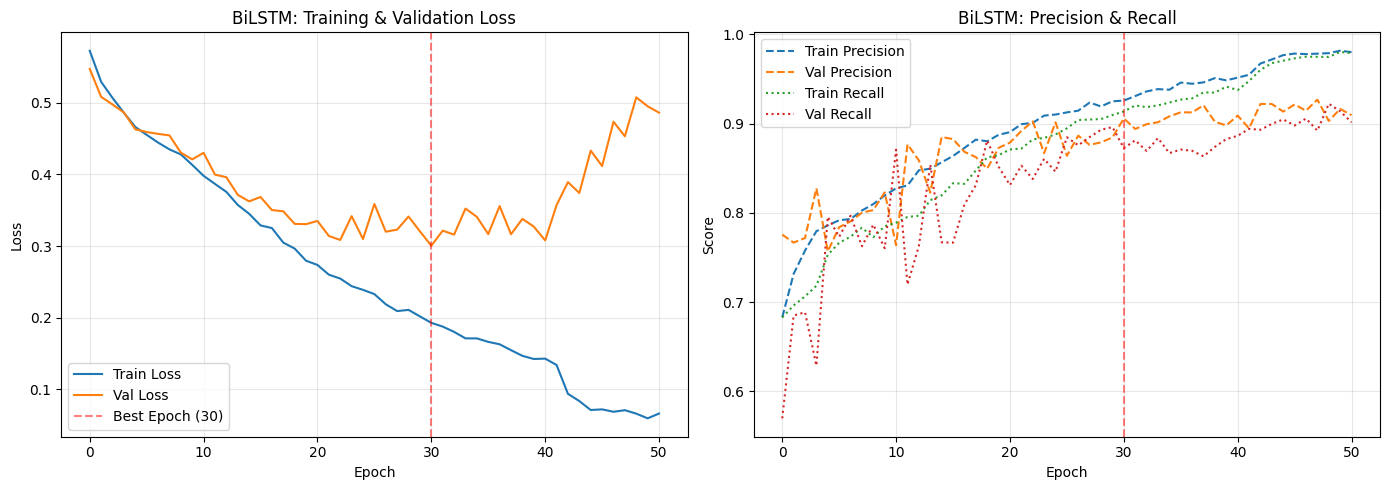

In [ ]:
# Train Bidirectional LSTM (Simpler Alternative)
import torch.optim as optim
import torch.nn.functional as F
import bilstm_model as bm

print("="*60)
print("TRAINING BIDIRECTIONAL LSTM")
print("="*60)
print("Rationale:")
print("  - BiLSTM naturally models temporal sequences")
print("  - Simpler than transformer, better for sequential data")
print("  - Forward+backward LSTM captures approach/departure patterns")
print("="*60)

# Hyperparameters
epochs = 100
lr = 0.001
batch_size = 32
patience = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")

# Create BiLSTM model
bilstm_model = bm.BidirectionalLSTMIntentClassifier(
    input_size=dim,  # Will be 68 (34 pose + 34 velocity)
    hidden_size=128,
    num_layers=2,
    dropout=0.3,
    output_size=1,
).to(device)

print(f"BiLSTM parameters: {bm.count_parameters(bilstm_model):,}")
print(f"Architecture: input={dim}, hidden=128, layers=2, bidirectional")

# Class weighting - compute natural pos weight and use BCEWithLogitsLoss
pos_weight_raw = (len(y) - float(y.sum())) / (float(y.sum()) + 1e-8)
pos_weight = float(pos_weight_raw)
print(f"Class weight (natural): {pos_weight_raw:.2f}x")
print(f"Rationale: adjust pos weight to account for class imbalance")
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor, reduction='none')
optimizer = optim.Adam(bilstm_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-5)

# Training loop
min_val_loss = None
patience_tracker = 0
best_epoch = 0
best_model_wts = None
history = {'train_loss': [], 'val_loss': [], 'train_recall': [], 'val_recall': [], 'train_precision': [], 'val_precision': []}

for epoch in range(epochs):
    train_rates = np.array([0,0,0,0])
    val_rates = np.array([0,0,0,0])
    
    # Training
    bilstm_model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)
        
        optimizer.zero_grad()
        logits = bilstm_model(x_batch)
        
        loss_per_sample = criterion(logits, y_batch)
        loss = loss_per_sample.mean()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        
        # Compute metrics from probabilities
        probs = torch.sigmoid(logits)
        y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
        y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
        tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
        tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
        fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
        fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
        train_rates += np.array([tp, tn, fp, fn])
    
    train_loss /= len(train_loader)
    train_precis = train_rates[0] / (train_rates[0] + train_rates[2] + 1e-10)
    train_recall = train_rates[0] / (train_rates[0] + train_rates[3] + 1e-10)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_precision'].append(train_precis)
    
    # Validation
    bilstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)
            
            logits = bilstm_model(x_batch)
            
            loss_per_sample = criterion(logits, y_batch)
            loss = loss_per_sample.mean()
            
            val_loss += loss.item()
            
            # Compute metrics
            probs = torch.sigmoid(logits)
            y_pred_np = (probs.cpu().detach().numpy() > 0.5).astype(int).flatten()
            y_batch_np = y_batch.cpu().detach().numpy().astype(int).flatten()
            
            tp = ((y_pred_np == 1) & (y_batch_np == 1)).sum()
            tn = ((y_pred_np == 0) & (y_batch_np == 0)).sum()
            fp = ((y_pred_np == 1) & (y_batch_np == 0)).sum()
            fn = ((y_pred_np == 0) & (y_batch_np == 1)).sum()
            val_rates += np.array([tp, tn, fp, fn])
    
    val_loss /= len(val_loader)
    val_precis = val_rates[0] / (val_rates[0] + val_rates[2] + 1e-10)
    val_recall = val_rates[0] / (val_rates[0] + val_rates[3] + 1e-10)
    history['val_loss'].append(val_loss)
    history['val_recall'].append(val_recall)
    history['val_precision'].append(val_precis)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if min_val_loss is None or val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_tracker = 0
        best_epoch = epoch
        best_model_wts = bilstm_model.state_dict().copy()
    else:
        patience_tracker += 1
    
    if epoch % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, "
              f"train_p={train_precis:.3f}, train_r={train_recall:.3f}, "
              f"val_p={val_precis:.3f}, val_r={val_recall:.3f}, lr={current_lr:.6f}")
    
    if patience_tracker >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nBest epoch: {best_epoch}, val_loss={min_val_loss:.3f}")
print(f"Best val_precision={val_precis:.3f}, val_recall={val_recall:.3f}")
print(f"Best F1-score: {2 * val_precis * val_recall / (val_precis + val_recall + 1e-10):.3f}")

# Load best model weights
if best_model_wts is not None:
    bilstm_model.load_state_dict(best_model_wts)

# Save BiLSTM model
save_path_bilstm = os.path.join(save_dir, "bilstm_model.pth")
torch.save(bilstm_model.state_dict(), save_path_bilstm)
print(f"\nBiLSTM model saved to {save_path_bilstm}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].axvline(best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('BiLSTM: Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['train_precision'], label='Train Precision', linestyle='--')
axes[1].plot(history['val_precision'], label='Val Precision', linestyle='--')
axes[1].plot(history['train_recall'], label='Train Recall', linestyle=':')
axes[1].plot(history['val_recall'], label='Val Recall', linestyle=':')
axes[1].axvline(best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('BiLSTM: Precision & Recall')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

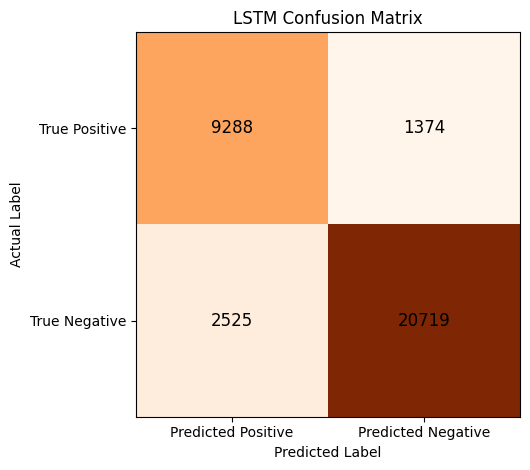

In [ ]:
arr = [9288, 20719, 2525, 1374]
d.plot_confusion_matrix(arr)

In [ ]:
import os, glob, pickle, random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
import numpy as np
from IPython.display import HTML, display
import preprocess_vis_data as pv

# Custom unpickler to map saved DataPointSet from __main__ to preprocess_vis_data.DataPointSet
class DPSUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "DataPointSet" and module in {"__main__", "preprocess_vis_data"}:
            return pv.DataPointSet
        return super().find_class(module, name)

# Inline animation (no GIF saving) of a random person trajectory per preprocessed pickle
# Mint data is already camera-normalized (treat as robot frame); Dataverse data has been transformed to robot frame.
# We only visualize the human trajectories.
pkl_dir = "../../../datasets/processed"
pkl_paths = sorted(glob.glob(os.path.join(pkl_dir, "preproc_out_*.pkl")))
max_frames = 150  # cap frames per animation to keep output lightweight
min_len = 5       # drop sequences shorter than this many frames

if not pkl_paths:
    print("No preproc_out_*.pkl files found in processed directory.")

for path in pkl_paths:
    with open(path, "rb") as f:
        robot_trajs, human_trajs = DPSUnpickler(f).load()

    # filter very short trajectories
    human_trajs = [dp for dp in human_trajs if dp.data_points and min(pts.shape[1] for pts in dp.data_points.values()) >= min_len]

    if not human_trajs:
        print(f"{os.path.basename(path)} has no human trajectories meeting min_len={min_len}; skipping.")
        continue

    dp = random.choice(human_trajs)
    seq_len = min(pts.shape[1] for pts in dp.data_points.values())

    n_frames = min(seq_len, max_frames)
    frame_idxs = list(range(n_frames))

    # Collect all points for consistent axis limits
    all_y = np.concatenate([pts[1, :n_frames] for pts in dp.data_points.values()])
    all_z = np.concatenate([pts[2, :n_frames] for pts in dp.data_points.values()])
    y_margin = (all_y.max() - all_y.min()) * 0.1 + 1e-3
    z_margin = (all_z.max() - all_z.min()) * 0.1 + 1e-3

    fig, ax = plt.subplots(figsize=(5, 5))
    scat = ax.scatter([], [], c="steelblue")
    ax.set_xlim(all_y.min() - y_margin, all_y.max() + y_margin)
    ax.set_ylim(all_z.min() - z_margin, all_z.max() + z_margin)
    ax.axhline(0, color="gray", lw=0.5)
    ax.axvline(0, color="gray", lw=0.5)
    ax.set_xlabel("normalized y")
    ax.set_ylabel("normalized z")
    ax.set_aspect("equal")

    def update(frame_idx):
        ys, zs = [], []
        for pts in dp.data_points.values():
            if frame_idx < pts.shape[1]:
                ys.append(pts[1, frame_idx])
                zs.append(pts[2, frame_idx])
        scat.set_offsets(np.column_stack([ys, zs]))

        label_val = None
        if dp.labels is not None and frame_idx < len(dp.labels):
            try:
                label_val = int(np.array(dp.labels[frame_idx]).astype(int).flatten()[0])
            except Exception:
                label_val = dp.labels[frame_idx]
        title = f"{os.path.basename(path)} | frame {frame_idx} (len {seq_len})"
        if label_val is not None:
            title += f" | label {label_val}"
        ax.set_title(title)
        return scat,

    ani = FuncAnimation(fig, update, frames=frame_idxs, interval=100, blit=True)
    display(HTML(ani.to_jshtml()))
    plt.close(fig)


In [ ]:
# Facing-direction animation
import facing_estimator as fe
import random, glob, pickle, os
from IPython.display import HTML, display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import importlib
import facing_estimator as fe

importlib.reload(fe)

# Ensure `human_trajs` loaded (earlier cells do this). If not, load pickles.
try:
    human_trajs
except NameError:
    import preprocess_vis_data as pv
    class DPSUnpickler(pickle.Unpickler):
        def find_class(self, module, name):
            if name == 'DataPointSet' and module in {'__main__', 'preprocess_vis_data'}:
                return pv.DataPointSet
            return super().find_class(module, name)
    pkl_dir = '../../../datasets/processed'
    pkl_paths = sorted(glob.glob(os.path.join(pkl_dir, 'preproc_out_*.pkl')))
    human_trajs = []
    for path in pkl_paths:
        with open(path, 'rb') as f:
            r,h = DPSUnpickler(f).load()
        human_trajs.extend(h)

# pick a trajectory with enough frames
min_len = 10
human_trajs = [dp for dp in human_trajs if dp.data_points and min(pts.shape[1] for pts in dp.data_points.values()) >= min_len]
if not human_trajs:
    raise RuntimeError('No suitable human trajectories found')
dp = random.choice(human_trajs)
seq_len = min(pts.shape[1] for pts in dp.data_points.values())
print('Selected trajectory length', seq_len)

# --- Normalize dp keys (paste immediately after dp is selected) ---
MINT_TO_TRAINING = {
    "Nose":"nose","Left Eye":"eye_left","Right Eye":"eye_right",
    "Left Ear":"ear_left","Right Ear":"ear_right",
    "Left Shoulder":"shoulder_left","Right Shoulder":"shoulder_right",
    "Left Elbow":"elbow_left","Right Elbow":"elbow_right",
    "Left Wrist":"wrist_left","Right Wrist":"wrist_right",
    "Left Hip":"hip_left","Right Hip":"hip_right",
    "Left Knee":"knee_left","Right Knee":"knee_right",
    "Left Ankle":"ankle_left","Right Ankle":"ankle_right",
}
raw_keys = list(dp.data_points.keys())
if any(k and k[0].isupper() for k in raw_keys):
    dp.data_points = {MINT_TO_TRAINING.get(k, k.lower()): v for k, v in dp.data_points.items()}
else:
    dp.data_points = {k.lower(): v for k, v in dp.data_points.items()}

importlib.reload(fe)
res = fe.estimate_facing_from_dptset(dp, smooth=True)
print('Computed yaw for frames:', len(res['yaw_deg']), ' yaw min/max:', float(np.min(res['yaw_deg'])), float(np.max(res['yaw_deg'])))

res = fe.estimate_facing_from_dptset(dp, smooth=True)
print('Computed yaw for frames:', len(res['yaw_deg']))

# Prepare plotting data
left_sh = dp.data_points.get('shoulder_left')
right_sh = dp.data_points.get('shoulder_right')
nose = dp.data_points.get('nose')
ys_all = np.concatenate([pts[1,:seq_len] for pts in dp.data_points.values()])
zs_all = np.concatenate([pts[2,:seq_len] for pts in dp.data_points.values()])
y_margin = (ys_all.max()-ys_all.min())*0.1 + 1e-3
z_margin = (zs_all.max()-zs_all.min())*0.1 + 1e-3

fig, ax = plt.subplots(figsize=(6,6))
scat = ax.scatter([], [], c='steelblue')
ax.set_xlim(ys_all.min()-y_margin, ys_all.max()+y_margin)
ax.set_ylim(zs_all.min()-z_margin, zs_all.max()+z_margin)
ax.set_xlabel('normalized y')
ax.set_ylabel('normalized z')
ax.set_aspect('equal')

# create a persistent arrow patch and add it once to the axes; update its endpoints each frame
arrow = FancyArrowPatch((0, 0), (0, 0), color='red', mutation_scale=15, lw=2)
ax.add_patch(arrow)

frame_idxs = list(range(seq_len))

def anchor_at(frame_idx):
    if left_sh is not None and right_sh is not None:
        if frame_idx < left_sh.shape[1] and frame_idx < right_sh.shape[1]:
            mid = 0.5*(left_sh[:2,frame_idx] + right_sh[:2,frame_idx])
            return mid[0], mid[1]
    if nose is not None and frame_idx < nose.shape[1]:
        return nose[1,frame_idx], nose[2,frame_idx]
    return 0.0, 0.0

def update(fi):
    ys, zs = [], []
    for pts in dp.data_points.values():
        if fi < pts.shape[1]:
            ys.append(pts[1, fi])
            zs.append(pts[2, fi])
    scat.set_offsets(np.column_stack([ys, zs]))
    yaw = float(res['yaw_deg'][fi])
    conf = float(res['confidence'][fi])
    ox, oz = anchor_at(fi)
    ang = np.deg2rad(yaw)
    L = 0.5 + 1.5*conf
    dx = L * np.sin(ang)
    dz = L * np.cos(ang)
    # update persistent arrow endpoints rather than re-creating artists or setting ax.collections
    arrow.set_positions((ox, oz), (ox + dx, oz + dz))
    method = res['method'][fi] if fi < len(res['method']) else 'unknown'
    title = f'Frame {fi} | yaw={yaw:.1f}° | conf={conf:.2f} | method={method}'
    ax.set_title(title)
    return scat, arrow

ani = FuncAnimation(fig, update, frames=frame_idxs, interval=100, blit=False)
display(HTML(ani.to_jshtml()))
plt.close(fig)

Selected trajectory length 80
Computed yaw for frames: 80  yaw min/max: -69.07169342041016 33.98567581176758
Computed yaw for frames: 80
